## Setup

In [22]:
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.filters import *
from skimage import measure
import imutils
import cv2

## Import image

In [23]:
image = imread("./images/1.png", as_gray=True)

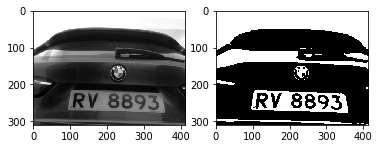

In [25]:
unnormalized_image = image * 255
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(unnormalized_image, cmap=plt.cm.gray)
threshold_value = threshold_minimum(unnormalized_image)
binary_image = unnormalized_image > threshold_value
ax2.imshow(binary_image, cmap=plt.cm.gray)
plt.show()

## Analyse

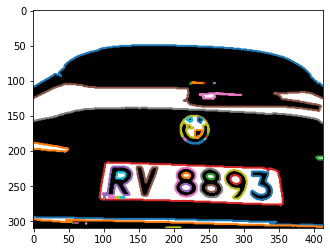

In [39]:
fig, (ax1) = plt.subplots(1)
contours = measure.find_contours(binary_image, 0.8)
ax1.imshow(binary_image, cmap=plt.cm.gray)

for n, contour in enumerate(contours):
    ax1.plot(contour[:, 1], contour[:, 0], linewidth=2)

plt.show()
